# 1. SETTINGS

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.metrics import log_loss
from sklearn.neighbors import NearestNeighbors
import copy
import scipy.stats
import os
import time
import requests

/Users/nikita.kozodoi/anaconda3/envs/py3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# pandas options
pd.set_option('display.max_columns', None)

In [3]:
# dark background style
plt.style.use('dark_background')

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# garbage collection
import gc
gc.enable()

In [6]:
# helper functions
import functions
from functions import *

# 2. DATA PREPARATION

In [7]:
# import CSV
df = pd.read_csv('../data/data_v2.csv')
print(df.shape)

(371928, 35)


In [8]:
# target variable
target = 'granted_number_of_nights'

In [9]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)

(297739, 35)
(74189, 35)


In [10]:
# target variable
y = train[target]
del train[target], test[target]
classes = y.unique()
classes

array([1., 2., 0., 3.])

# 3. MODELING

In [19]:
### LOSS FUNCTION
def multi_weighted_logloss(y_true, y_preds):
    
    classes = [0, 1, 2, 3]
    class_weight = {0:1, 1:10, 2:100, 3:1000}
    
    # reshape
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order = 'F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a = y_p, a_min = 1e-15, a_max = 1-1e-15)
    
    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis = 0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis = 0).values.astype(float)
    
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return 'wloss', loss, False


# recompute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

### PARAMETERS

In [20]:
# drop bad features
excluded_feats = ['request_id', 'group_id', 'group_main_requester_id', 'request_backoffice_creator_id', 
                  'answer_creation_date', 'group_creation_date', 'request_creation_date']
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(297739, 29)


In [21]:
### PARAMETERS

# settings
cores = -1
seed  = 23

# cross-validation
num_folds = 4
shuffle   = True

# muner of rounds
max_rounds = 400
stopping   = 200
verbose    = 50

# LGB parameters
lgb_params = {
    'boosting_type':     'gbdt',
    'objective':         'multiclass',
    'metric':            'None',
    'num_class':         len(classes),
    'bagging_fraction':  0.9,
    'feature_fraction':  0.9,
    'lambda_l1':         0.1,
    'lambda_l2':         0.1,
    'min_split_gain':    0,
    'min_child_weight':  0.1,
    'min_child_samples': 20,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.1,
    'max_depth':         5,
    'num_leaves':        50,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
}

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

In [22]:
# placeholders
clfs = []
valid_perf  = np.zeros(num_folds) 
importances = pd.DataFrame()

#preds_test   = np.zeros(test.shape[0])
#preds_oof    = np.zeros(train.shape[0])

preds_oof  = np.zeros((len(train), len(classes)))
preds_test = np.zeros((len(test),  len(classes)))

In [23]:
# SMOTE settings
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state = 23, n_jobs = 10, sampling_strategy = 0.1)

### CROSS-VALIDATION

In [26]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    test_x       = test[features]
    
    ## remove outliers
    #out_idx = (np.abs(scipy.stats.zscore(trn_x)) < 10).all(axis = 1)
    #trn_x = trn_x[out_idx]
    #trn_y = trn_y[out_idx]
    
    # scale data
    #scaler   = RobustScaler()
    #trn_x    = pd.DataFrame(scaler.fit_transform(trn_x), columns = features)
    #val_x    = pd.DataFrame(scaler.transform(val_x),     columns = features)
    #tmp_test = pd.DataFrame(scaler.transform(test_x),    columns = features)

    # augment training data with SMOTE
    #trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    #trn_x = pd.DataFrame(trn_x, columns = features)
    #trn_y = pd.Series(trn_y)
       
    # add noise to train to reduce overfitting
    #trn_x += np.random.normal(0, 0.01, trn_x.shape)
        
    # train lightGBM
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = multi_weighted_logloss,
                  early_stopping_rounds = stopping,
                  verbose               = verbose,
                  sample_weight         = 10**trn_y
)
    clfs.append(clf)
    
    # find the best iteration
    best_iter = clf.best_iteration_

    # save predictions
    #preds_oof[val_idx]    = clf.predict_proba(val_x,  num_iteration = best_iter)[:, 1]
    #valid_profit[n_fold]  = log_loss(y, preds_oof)
    #preds_test           += clf.predict_proba(test_x, num_iteration = best_iter)[:, 1] / folds.n_splits 
    
    # save predictions
    preds_oof[val_idx, :] = clf.predict_proba(val_x, num_iteration = best_iter)
    valid_perf[n_fold]    = log_loss(y[val_idx], preds_oof[val_idx, :], sample_weight = 10**y[val_idx])
    preds_test           += clf.predict_proba(test_x, num_iteration = best_iter) / folds.n_splits 

    # importance
    fold_importance_df               = pd.DataFrame()
    fold_importance_df['Feature']    = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold']       = n_fold + 1
    importances                      = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: LOGLOSS = %.6f' % (n_fold + 1, valid_perf[n_fold]))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    
# print overall performance    
cv_perf = np.mean(valid_perf)
print('--------------------------------')
print('MEAN LOGLOSS = %.6f' % cv_perf)
print('--------------------------------')

Training until validation scores don't improve for 200 rounds.
[50]	training's wloss: 0.430725	valid_1's wloss: 0.569246
[100]	training's wloss: 0.36524	valid_1's wloss: 0.576188
[150]	training's wloss: 0.322177	valid_1's wloss: 0.611723
[200]	training's wloss: 0.289225	valid_1's wloss: 0.652554
[250]	training's wloss: 0.262194	valid_1's wloss: 0.692706
Early stopping, best iteration is:
[69]	training's wloss: 0.399988	valid_1's wloss: 0.563845
--------------------------------
FOLD 1: LOGLOSS = 0.581434
--------------------------------

Training until validation scores don't improve for 200 rounds.
[50]	training's wloss: 0.446225	valid_1's wloss: 0.531386
[100]	training's wloss: 0.373824	valid_1's wloss: 0.540653
[150]	training's wloss: 0.329142	valid_1's wloss: 0.578764
[200]	training's wloss: 0.293293	valid_1's wloss: 0.61849
[250]	training's wloss: 0.267765	valid_1's wloss: 0.663142
Early stopping, best iteration is:
[68]	training's wloss: 0.413773	valid_1's wloss: 0.527669
--------

In [30]:
##### RECHECK PERFORMANCE  

# define the competition scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight = 10**y_true)

##### RECHECK PERFORMANCE  
print(competition_scorer(y, preds_oof))


###### TRACKING RESULTS (5 folds, strat = True, seed = 4)

# V2: 

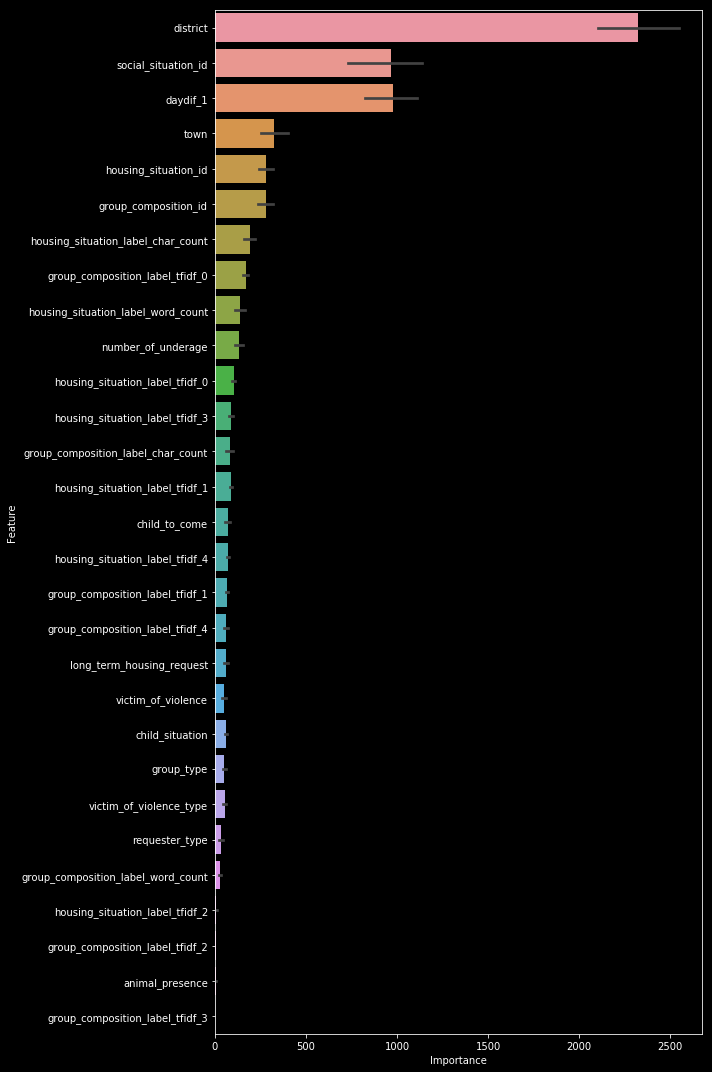

In [31]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 100
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 15))
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False))
plt.tight_layout()

# save plot as pdf
plt.savefig('../var_importance.pdf')

# 4. SUBMISSION

In [32]:
# file name
model = 'lgb_v4'
perf  = str(round(cv_perf, 6))[2:7]
name  = model + '_' + perf

In [33]:
# export OOF preds
#oof = pd.DataFrame({'id': train['id'], 'duration': preds_oof})
#oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
#oof.head()

In [34]:
# export submission
#sub = pd.DataFrame({'id': test['id'], 'duration': preds_test})
#sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
#sub.head()

In [35]:
# export OOF preds
oof = pd.DataFrame(preds_oof)
oof.insert(0, column = 'request_id', value = train['request_id'].reset_index(drop = True))
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,request_id,0,1,2,3
0,130667d2964de43c511d0ead7ac66b33,0.037324,0.802640,0.156373,0.003664
1,b1cd62fcf24eebb0f685d5eaf55317a8,0.096069,0.697865,0.179435,0.026631
2,12cc0a18890bd4959fe42df3ae58838e,0.246537,0.209527,0.337732,0.206204
3,ae2d5b4dc181d29e430132f145da1556,0.061310,0.330569,0.404624,0.203497
4,d13a17ce36c832514fda2464e11c4a9f,0.000388,0.017326,0.951475,0.030811


In [36]:
# export submission
sub = pd.DataFrame(preds_test)
sub.insert(0, column = 'request_id', value = test['request_id'].reset_index(drop = True))
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.head()

,request_id,0,1,2,3
0,7a2f7215846392375b7e5f4a416298aa,0.002832,0.329439,0.447854,0.219875
1,f9388302f1a12ff58a9cabad201b24c4,0.130532,0.358362,0.298542,0.212564
2,482f122fbc7333eda62ca9efee6fbeb2,0.004350,0.194878,0.757449,0.043323
3,0676b42f6d679cfaee0e2633fc793a00,0.246893,0.111277,0.323828,0.318003
4,c857c384143351e1baf335648508e8c5,0.018681,0.760622,0.207264,0.013433


In [38]:
##########
##########
########## SUBMIT TO QSCORE


import io, math, requests

# Get your token from qscore:
# 1. Go to https://qscore.datascience-olympics.com/
# 2. Chose the competition Data Science Olympics 2019
# 3. In the left menu click 'Submissions'
# 4. Your token is in the 'Submit from your Python Notebook' tab

def submit_prediction(df, sep=',', comment='', compression='gzip', **kwargs):
    TOKEN='e14ac5c20102ef4dc10712ec7838b44f48e227604d6a931ab92804ce785527ac43465fdfbc5bd8269a92cf32fffd71fed365d3dfd95e029ac43c14e25cc5c788'
    URL='https://qscore.datascience-olympics.com/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [39]:
# submit to QSCORE
comment = ''
submit_prediction(sub, sep = ',', index = False, comment = str(comment) + ' - ' + name)

Exception: <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1"/>
<title>502 - Web server received an invalid response while acting as a gateway or proxy server.</title>
<style type="text/css">
<!--
body{margin:0;font-size:.7em;font-family:Verdana, Arial, Helvetica, sans-serif;background:#EEEEEE;}
fieldset{padding:0 15px 10px 15px;} 
h1{font-size:2.4em;margin:0;color:#FFF;}
h2{font-size:1.7em;margin:0;color:#CC0000;} 
h3{font-size:1.2em;margin:10px 0 0 0;color:#000000;} 
#header{width:96%;margin:0 0 0 0;padding:6px 2% 6px 2%;font-family:"trebuchet MS", Verdana, sans-serif;color:#FFF;
background-color:#555555;}
#content{margin:0 0 0 2%;position:relative;}
.content-container{background:#FFF;width:96%;margin-top:8px;padding:10px;position:relative;}
-->
</style>
</head>
<body>
<div id="header"><h1>Server Error</h1></div>
<div id="content">
 <div class="content-container"><fieldset>
  <h2>502 - Web server received an invalid response while acting as a gateway or proxy server.</h2>
  <h3>There is a problem with the page you are looking for, and it cannot be displayed. When the Web server (while acting as a gateway or proxy) contacted the upstream content server, it received an invalid response from the content server.</h3>
 </fieldset></div>
</div>
</body>
</html>
